# Sieć klasyfikacji binarnej
Klasyfikuje obiekty na 2 różne typy (np. czy jest to kot czy pies)

In [33]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

#Ustawienie domyślnego urządzenia
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Przygotowanie danych

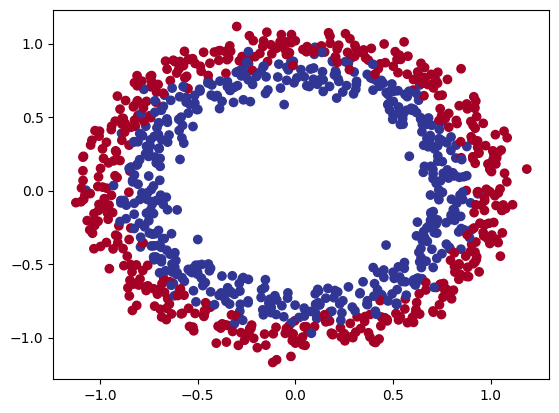

In [34]:
X, y = make_circles(1000,
                   noise=0.07)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu')

#### Zamiana typu danych z array na tensory

In [35]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

#### Podział danych na dane testowe i treningowe

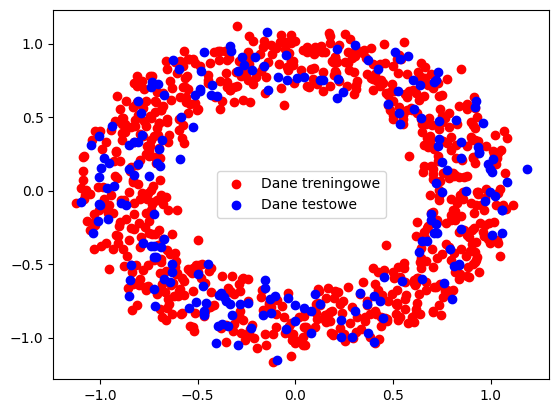

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plt.scatter(x_train[:, 0], x_train[:, 1], c='r', label='Dane treningowe')
plt.scatter(x_test[:, 0], x_test[:, 1], c='b', label='Dane testowe')
plt.legend()

## 2. Model sieci neuronowej z liniowymi funkcjami aktywacji

In [37]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        #Warstwa wejściowa
        self.input_layer = nn.Linear(in_features=2, out_features=8)
        #Warstwa wyjściowa
        self.output_layer = nn.Linear(in_features=8, out_features=1)
        
    #Forward pass    
    def forward(self, x):
        return self.output_layer(self.input_layer(x))

#Fabrykacja modelu
model_linear = ClassificationModel().to(device)
model_linear

ClassificationModel(
  (input_layer): Linear(in_features=2, out_features=8, bias=True)
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)

### Funkcja kosztu i optimier

In [38]:
#Dodatkowe funkcje
optimizer = torch.optim.SGD(model_linear.parameters(),
                            lr=0.1)
loss_function = nn.BCEWithLogitsLoss()

In [39]:
#Dokładność sieci
def accuracy(pred, target):
    return (torch.eq(pred, target).sum().item()/len(pred))*100

### Przewidywania przed trenowaniem

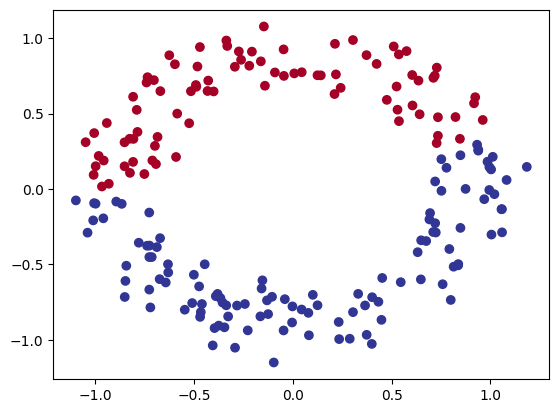

In [40]:
with torch.inference_mode():
    untrained_pred = torch.round(torch.sigmoid(model_linear(x_test.to(device))))
    
plt.scatter(x_test[:, 0], x_test[:, 1], c=untrained_pred.numpy(), cmap='RdYlBu')

## 3. Pętla treningowa

In [41]:
Epochs = 10000

epochs = []
losses = []
test_losses = []
x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)

for epoch in range(0, Epochs):
    model_linear.train()
    
    #___Training___
    #1. forward pass (logit - surowe outputy  sieci neuronowej)
    y_logits = model_linear(x_train).squeeze()
    
    #2. Loss
    loss = loss_function(y_logits, y_train)
    acc = accuracy(torch.round(torch.sigmoid(y_logits)), y_train)
    
    #3. Zero grad
    optimizer.zero_grad()
    
    #4. Backward pass
    loss.backward()
    
    #5. Optimier step
    optimizer.step()
    
    #___Testing___
    model_linear.eval()
    with torch.inference_mode():
        test_logits = model_linear(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_function(test_logits, y_test)
    test_acc = accuracy(test_pred, y_test)
    
    if epoch%(Epochs/10) == 0:
        print(f"Epoch: {epoch}, loss: {round(loss.item(), 4)}, accuracy: {round(acc, 2)}%, test loss: {round(test_loss.item(), 4)}, test accuracy: {round(test_acc, 2)}%")

Epoch: 0, loss: 0.7034, accuracy: 51.12%, test loss: 0.6953, test accuracy: 49.5%
Epoch: 1000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 2000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 3000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 4000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 5000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 6000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 7000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 8000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%
Epoch: 9000, loss: 0.6928, accuracy: 50.88%, test loss: 0.6964, test accuracy: 46.5%


### Przewidywania po trenowaniu

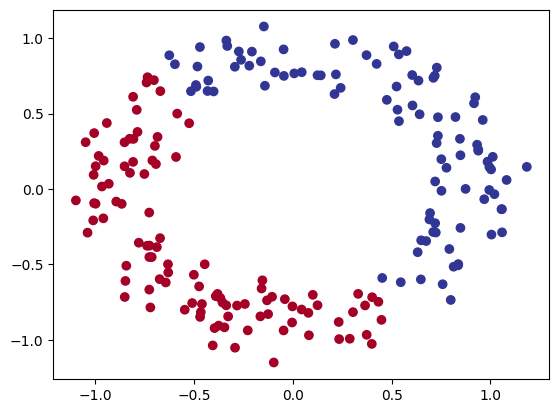

In [42]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=test_pred.numpy(), cmap='RdYlBu')

### Granica decyzyjna sieci

In [44]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("File already exists")
else:
    print("Downloading...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

File already exists


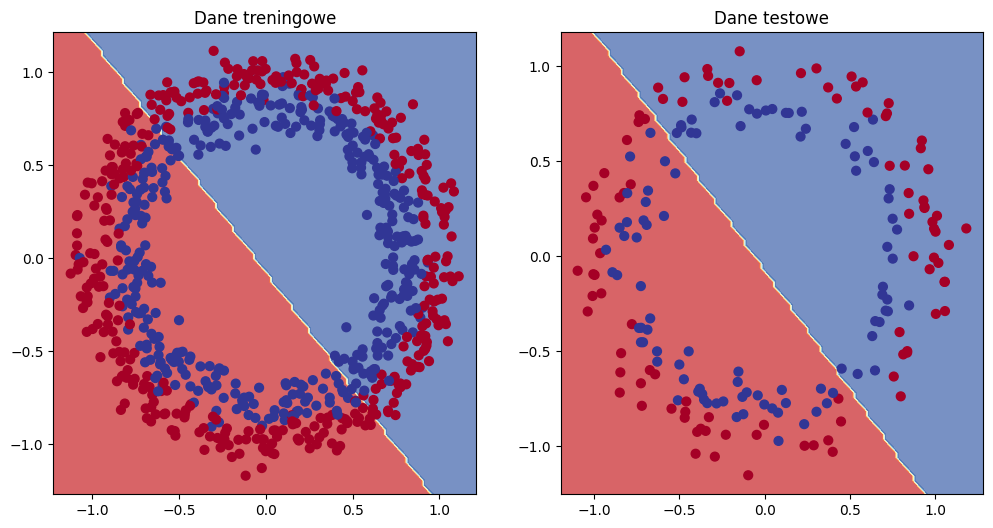

In [45]:
plt.figure(figsize=(12,  6))
plt.subplot(1, 2, 1)
plt.title("Dane treningowe")
plot_decision_boundary(model_linear, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Dane testowe")
plot_decision_boundary(model_linear, x_test, y_test)

# 4. Nowa lepsza sieć
Więcej neuronów, kolejna warstwa, lepszy optimizer, nieliniowa funkcja aktywacyjna

In [46]:
class ClassificationModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=64)
        self.layer2 = nn.Linear(in_features=64, out_features=64)
        self.layer3 = nn. Linear(in_features=64, out_features=1)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        return self.layer3(self.ReLU(self.layer2(self.ReLU(self.layer1(x)))))
    
modelV2 = ClassificationModelV2().to(device)
modelV2

ClassificationModelV2(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (ReLU): ReLU()
)

In [48]:
#Optimizer i funkcja kosztu
optimizer = torch.optim.Adam(modelV2.parameters(),
                            lr=0.1)
loss_fun = nn.BCEWithLogitsLoss()

### Przewidywania przed trenowaniem

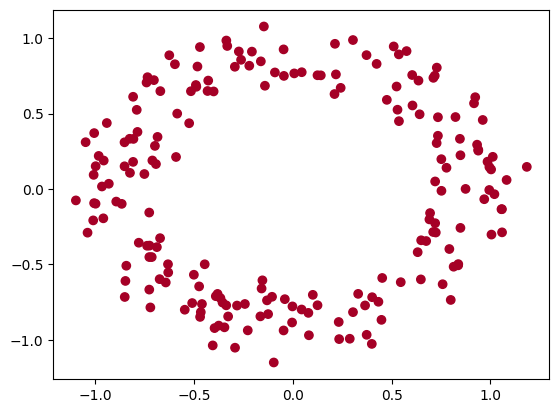

In [49]:
with torch.inference_mode():
    untrained_pred = torch.round(torch.sigmoid(modelV2(x_test.to(device))))
    
plt.scatter(x_test[:, 0], x_test[:, 1], c=untrained_pred.numpy(), cmap='RdYlBu')

### Pętla treningowa i testowa

In [50]:
Epochs = 1000

x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)

for epoch in range(Epochs):
    #___Trenowanie___
    modelV2.train()
    
    #1. Forward
    y_logits = modelV2(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #2. Koszt
    loss = loss_fun(y_logits, y_train)
    acc = accuracy(y_pred, y_train)
    
    #3. Zero grad
    optimizer.zero_grad()
    
    #4. Backward
    loss.backward()
    
    #5. Optimizer step
    optimizer.step()
    
    #___Testowanie___
    modelV2.eval()
    #Forward pass
    with torch.inference_mode():
        test_logits = modelV2(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
    #Koszt
    test_loss = loss_fun(test_logits, y_test)
    test_acc = accuracy(test_pred, y_test)
    
    #Print process
    if epoch%100 == 0:
        print(f"Epoch: {epoch} | Loss: {round(loss.item(), 4)} | Acc: {round(acc, 2)}% | Test loss: {round(test_loss.item(), 4)} | Test acc: {round(test_acc, 2)}%")

Epoch: 0 | Loss: 0.6943 | Acc: 49.88% | Test loss: 0.9087 | Test acc: 50.5%
Epoch: 100 | Loss: 0.1627 | Acc: 93.88% | Test loss: 0.2449 | Test acc: 89.5%
Epoch: 200 | Loss: 0.1508 | Acc: 93.88% | Test loss: 0.2546 | Test acc: 90.5%
Epoch: 300 | Loss: 0.1516 | Acc: 93.88% | Test loss: 0.2538 | Test acc: 90.0%
Epoch: 400 | Loss: 0.1466 | Acc: 93.38% | Test loss: 0.2619 | Test acc: 89.5%
Epoch: 500 | Loss: 0.1453 | Acc: 93.38% | Test loss: 0.2685 | Test acc: 90.5%
Epoch: 600 | Loss: 0.1453 | Acc: 93.88% | Test loss: 0.2765 | Test acc: 90.0%
Epoch: 700 | Loss: 0.139 | Acc: 94.12% | Test loss: 0.2849 | Test acc: 90.0%
Epoch: 800 | Loss: 0.1371 | Acc: 94.5% | Test loss: 0.3002 | Test acc: 90.5%
Epoch: 900 | Loss: 0.1404 | Acc: 94.25% | Test loss: 0.3045 | Test acc: 90.5%


### Przewidywania po trenowaniu

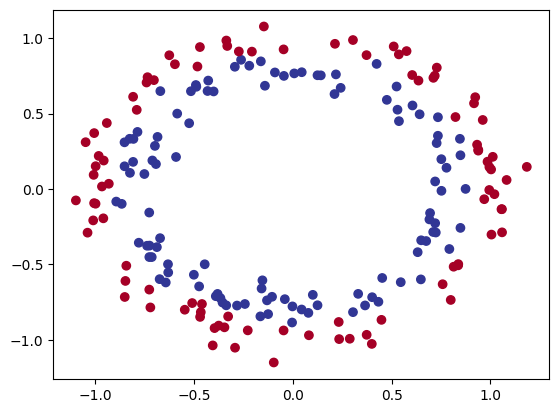

In [51]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=test_pred, cmap='RdYlBu')

### Granica decyzyjna modelu

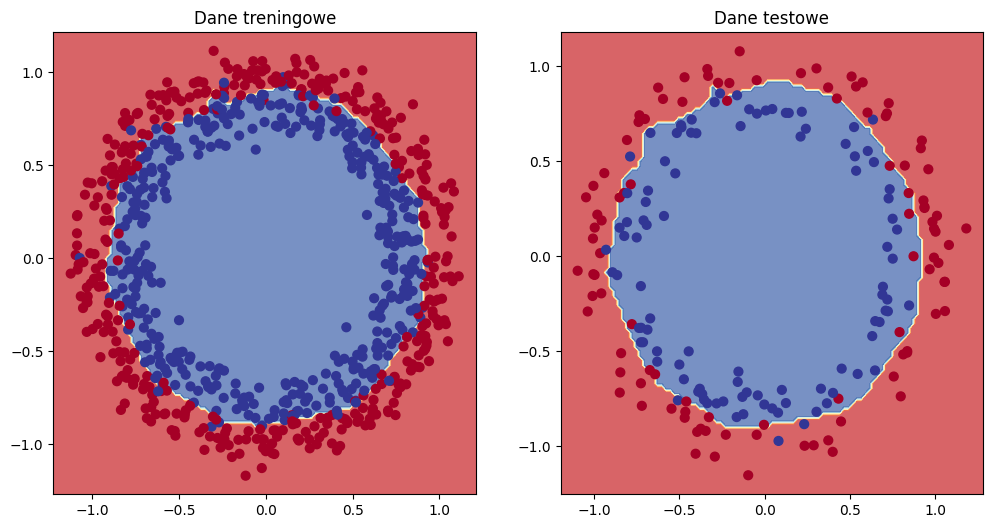

In [52]:
plt.figure(figsize=(12,  6))
plt.subplot(1, 2, 1)
plt.title("Dane treningowe")
plot_decision_boundary(modelV2, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Dane testowe")
plot_decision_boundary(modelV2, x_test, y_test)

# 5. Zapisywanie i wczytywanie modelu

### Zapisywanie

In [146]:
MODEL_NAME = 'Circle_classification.pt'
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(modelV2.state_dict(), MODEL_SAVE_PATH)

### Przed załadowaniem

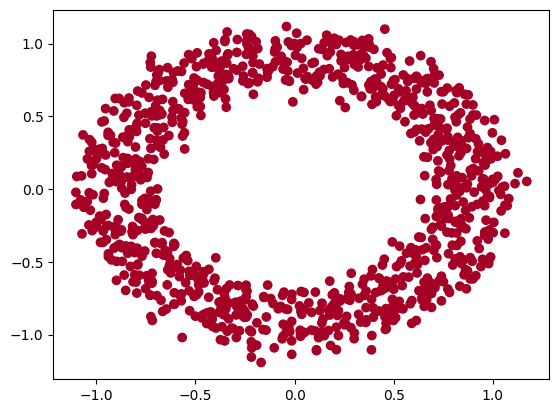

In [148]:
Model_loaded = ClassificationModelV2()
with torch.inference_mode():
    pred_load = torch.round(torch.sigmoid(Model_loaded(X)))

plt.scatter(X[:, 0], X[:, 1], c=pred_load, cmap='RdYlBu')

### Po załadowaniu

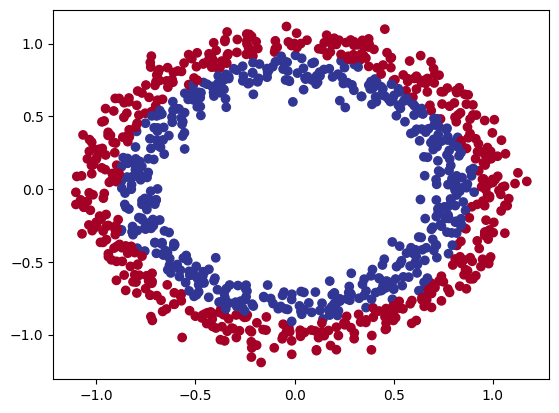

In [149]:
Model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
with torch.inference_mode():
    pred_load = torch.round(torch.sigmoid(Model_loaded(X)))

plt.scatter(X[:, 0], X[:, 1], c=pred_load, cmap='RdYlBu')